# Práctica 2: TCGA

## Objetivo de la práctica
TCGA (The Cancer Genome Atlas) es un proyecto colaborativo dirigido por el Instituto Nacional del Cáncer (NCI) y el Instituto Nacional de Investigación del Genoma Humano (NHGRI) en los Estados Unidos. Su objetivo principal es caracterizar exhaustivamente las alteraciones genómicas en el cáncer mediante el análisis de grandes conjuntos de datos de pacientes con cáncer. Se pretende crear un clasificador de cáncer que tenga en cuenta las probabilidades de pertenecer a una clase dependiendo de las distintas variables y sus valores. Usa scikit-learn junto con las librerías que necesites para resolver las siguientes cuestiones.

## 1) Preprocesamiento

### Se importan las librerías necesarias para la realización de la práctica.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

### Se importa el archivo de datos.

In [ ]:
data = pd.read_csv('TCGA.csv')

print(data.shape)
data.head()

(862, 27)


,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,TCGA-LGG,TCGA-DU-8164,Male,51 years 108 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-LGG,TCGA-QH-A6CY,Male,38 years 261 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,TCGA-LGG,TCGA-HW-A5KM,Male,35 years 62 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-LGG,TCGA-E1-A7YE,Female,32 years 283 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,TCGA-LGG,TCGA-S9-A6WG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


Se establecen los valores de la edad como números enteros correspondiendo a los años del individuo.

In [ ]:
for i in range(data.shape[0]):
  split = data.loc[i, 'Age_at_diagnosis'].split()

  if 'days' in split:
    data.loc[i, 'Age_at_diagnosis'] = int(split[0]) + int(split[2])/365

  else:
    data.loc[i, 'Age_at_diagnosis'] = split[0]

Se eliminan elementos repetidos y se estudia la presencia de elementos vacíos en el conjunto. Teniendo en cuenta el valor `--` que toman algunos registros como valor nulo.

In [ ]:
data = data.drop_duplicates()

data = data.replace('--', np.nan)

for col in data.isna():
  if data[col].isna().sum() != 0:
    print(col, ':', data[col].isna().sum())

Gender : 4
Age_at_diagnosis : 5
Primary_Diagnosis : 4
Race : 4


Se sustituyen los registros que contienen valores nulos en las columnas `Gender`, `Primary_Diagnosis` y `Race` cn el valor `not reported`. Para los valores de la columna `Age_at_diagnosis` se pueden sustituir por el valor medio para no alterar la distribución.

Por otro lado, se eliminan las columnas `Project` y `Case_ID` ya que la primera ofrece la misma información que la columna `Grade` y la segunda porque no aporta información relevante para la clasificación.

In [ ]:
data[['Gender', 'Primary_Diagnosis', 'Race']] = data[['Gender', 'Primary_Diagnosis',
                                                      'Race']].fillna('not reported')

mean = data['Age_at_diagnosis'].dropna().astype(int).mean()
data['Age_at_diagnosis'] = data['Age_at_diagnosis'].fillna(mean).astype(float)

data = data.drop(columns = ['Project', 'Case_ID'])

### Se categorizan los valores de edad en función de los cuartiles.

Para poder establecer las categorías, se deben primero calcular los cuartiles y después etiquetar cada valor con el nombre del cuartil correspondiente.

In [ ]:
def age(age, quartiles):
    if age <= quartiles[0.25]:
        return 'Q1'
    elif age <= quartiles[0.5]:
        return 'Q2'
    elif age <= quartiles[0.75]:
        return 'Q3'
    else:
        return 'Q4'

quartiles = data['Age_at_diagnosis'].quantile([0.25, 0.5, 0.75])

data['Age_at_diagnosis'] = data['Age_at_diagnosis'].apply(age, args = (quartiles, ))

### Se generan las tablas de distribución.

Se crea la tabla de distribución, siendo el índice `Características` el nombre de la columna original y el índice `Valores` las categorías de esta columna. Las columnas representan los diferentes diagnósticos. De esta forma, se puede representar la distribución de los diagnósticos en función de una característica concreta. Además, se sustituyen los valores nulos por `0` ya que indican que no se da ese valor.

In [ ]:
columns = data.drop(columns = 'Primary_Diagnosis').columns.sort_values()
idx = []

for col in columns:
  for v in data[col].sort_values().unique():
    idx.append([col, v])

idx = pd.MultiIndex.from_frame(pd.DataFrame(idx, columns = ['Características', 'Valores']))
cnt = pd.DataFrame(columns = data['Primary_Diagnosis'].sort_values().unique(),
                   index = idx)

for col in columns:
  c = [col, 'Primary_Diagnosis']
  count = pd.DataFrame(data.value_counts(c)).sort_values(c)
  count = count.groupby(c).sum().reset_index()

  for i in range(count[col].shape[0]):
    fila = (col, count.loc[i, col])
    columna = count.loc[i, 'Primary_Diagnosis']
    valor = count.loc[i, 'count']

    cnt.loc[fila, columna] = valor

cnt = cnt.fillna(0)
cnt

Astrocytoma, NOS  \
Características  Valores                                              
ATRX             MUTATED                                         36   
                 NOT_MUTATED                                     22   
Age_at_diagnosis Q1                                              34   
                 Q2                                              18   
                 Q3                                               4   
                 Q4                                               2   
BCOR             MUTATED                                          1   
                 NOT_MUTATED                                     57   
CIC              MUTATED                                          1   
                 NOT_MUTATED                                     57   
CSMD3            MUTATED                                          1   
                 NOT_MUTATED                                     57   
EGFR             MUTATED                                          1   
                 NOT_MUTATED                                     57   
FAT4             MUTATED                                          2   
                 NOT_MUTATED                                     56   
FUBP1            MUTATED                                          0   
                 NOT_MUTATED                                     58   
GRIN2A           MUTATED                                          0   
                 NOT_MUTATED                                     58   
Gender           Female                                          24   
                 Male                                            34   
                 not reported                                     0   
Grade            GBM                                              0   
                 LGG                                             58   
IDH1             MUTATED                                         51   
                 NOT_MUTATED                                      7   
IDH2             MUTATED                                          1   
                 NOT_MUTATED                                     57   
MUC16            MUTATED                                          6   
                 NOT_MUTATED                                     52   
NF1              MUTATED                                          2   
                 NOT_MUTATED                                     56   
NOTCH1           MUTATED                                          2   
                 NOT_MUTATED                                     56   
PDGFRA           MUTATED                                          0   
                 NOT_MUTATED                                     58   
PIK3CA           MUTATED                                          4   
                 NOT_MUTATED                                     54   
PIK3R1           MUTATED                                          1   
                 NOT_MUTATED                                     57   
PTEN             MUTATED                                          2   
                 NOT_MUTATED                                     56   
RB1              MUTATED                                          0   
                 NOT_MUTATED                                     58   
Race             american indian or alaska native                 0   
                 asian                                            1   
                 black or african american                        2   
                 not reported                                     2   
                 white                                           53   
SMARCA4          MUTATED                                          3   
                 NOT_MUTATED                                     55   
TP53             MUTATED                                         46   
                 NOT_MUTATED                                     12   

                                                   Astrocytoma, anaplastic

Se grafican las distribuciones de cada característica.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


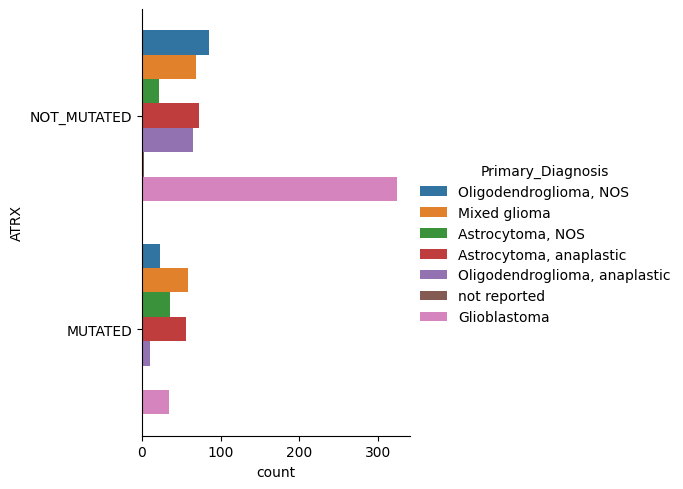

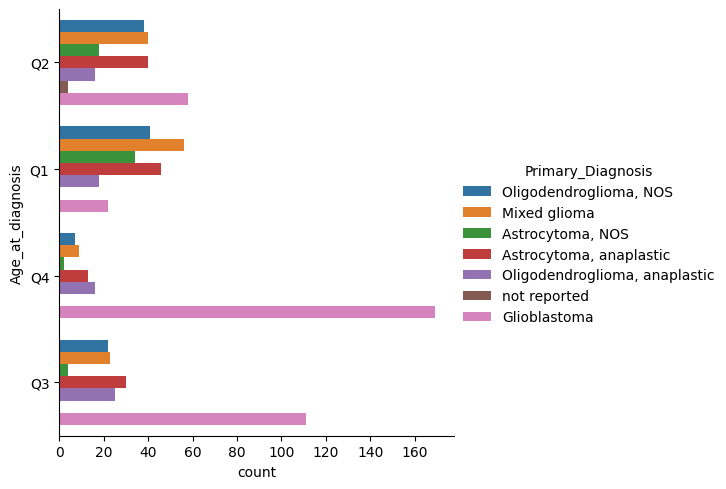

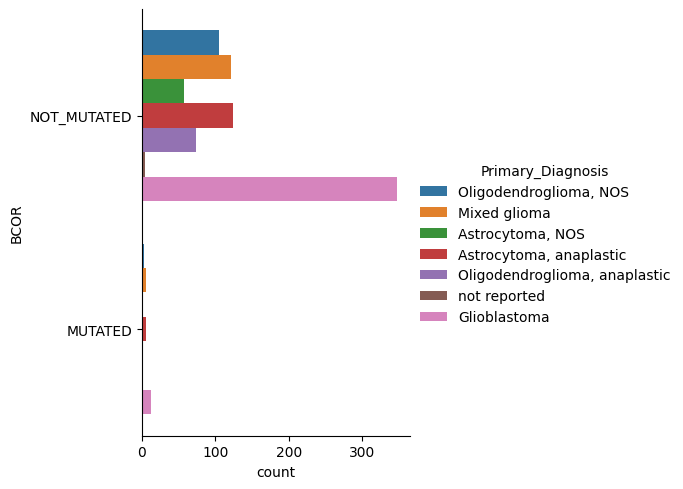

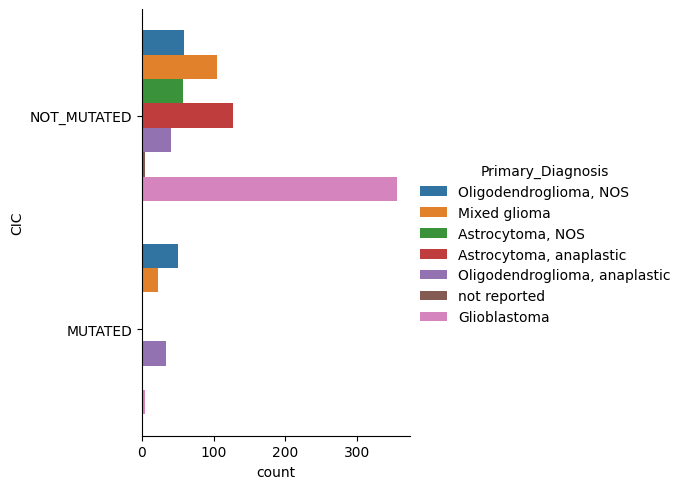

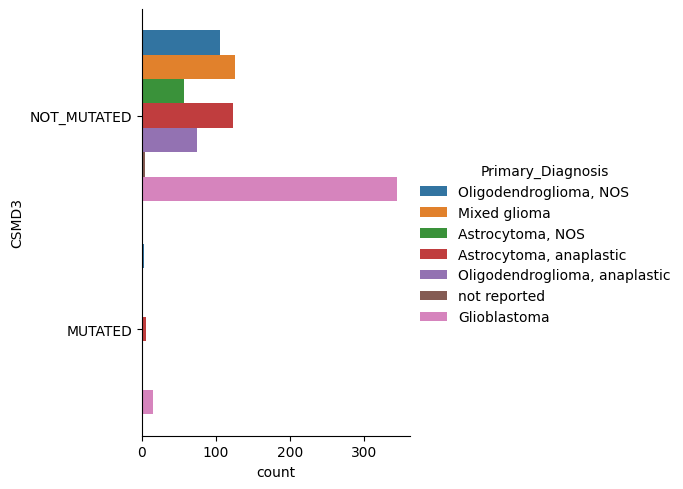

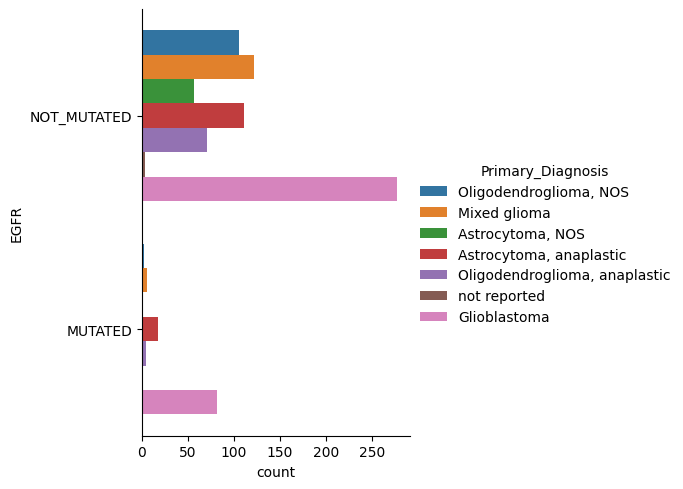

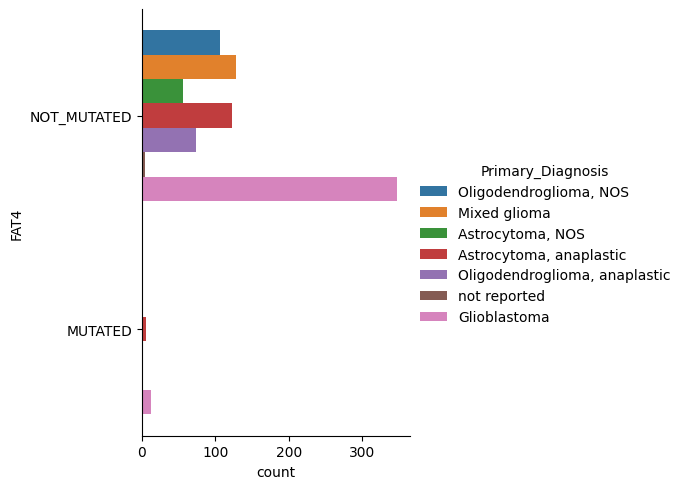

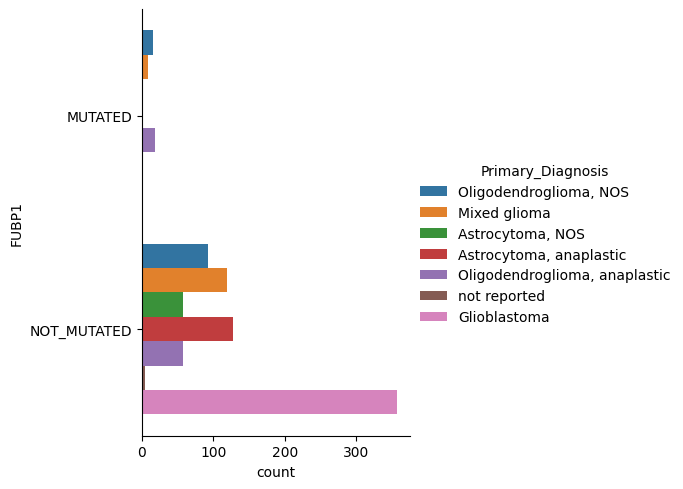

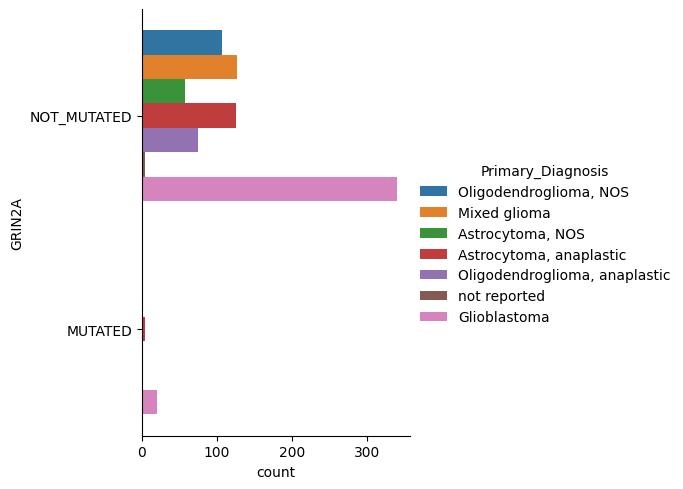

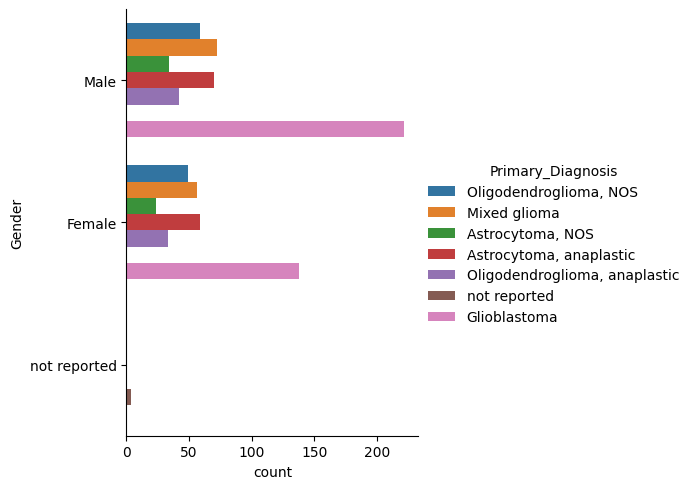

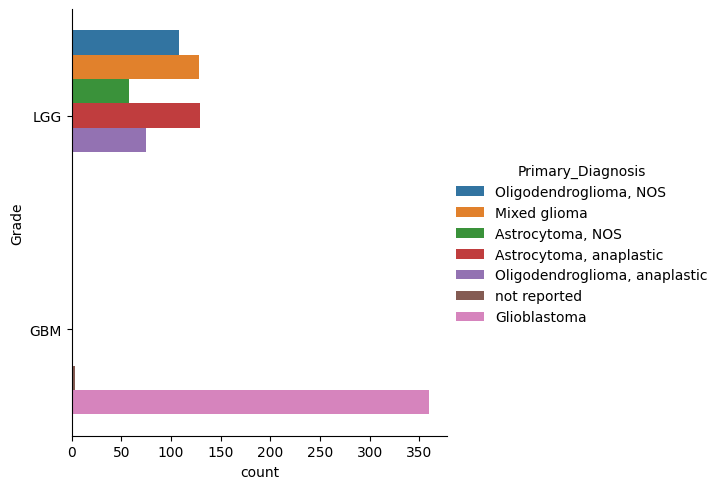

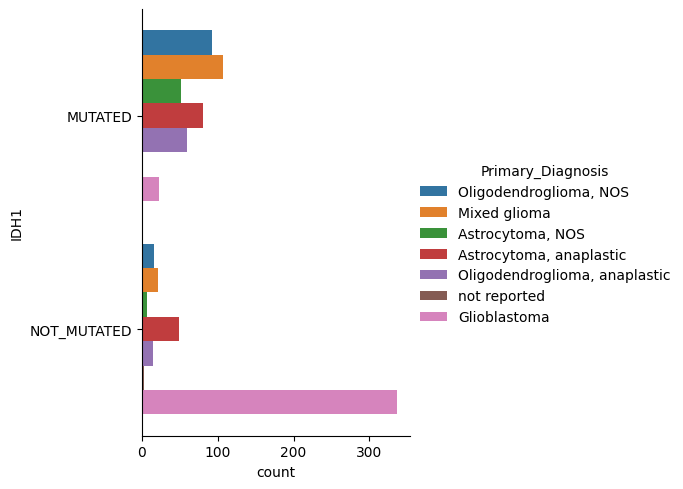

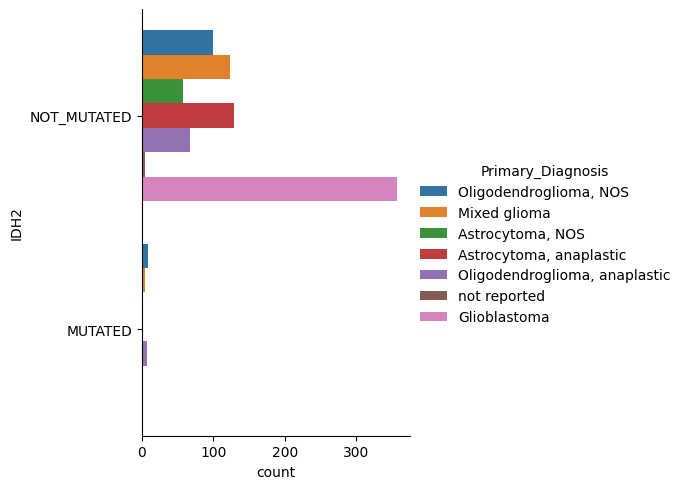

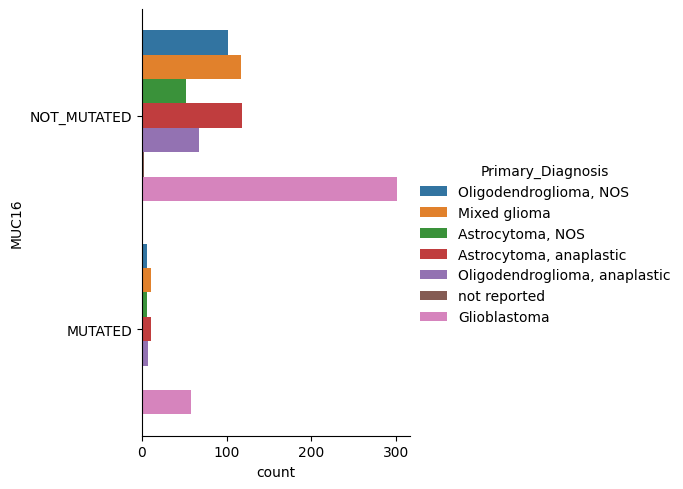

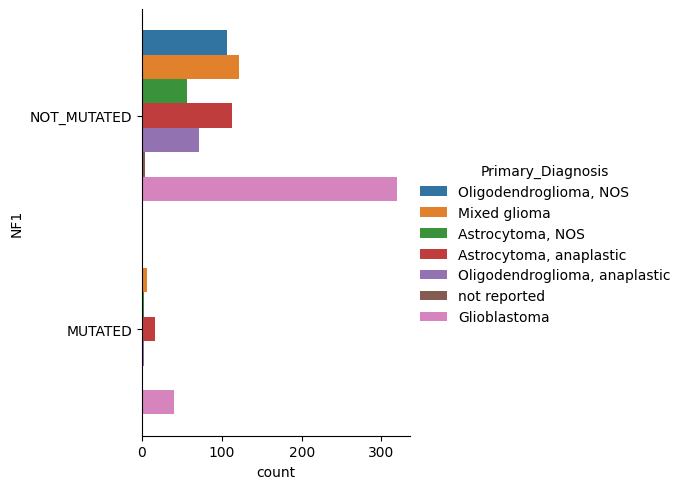

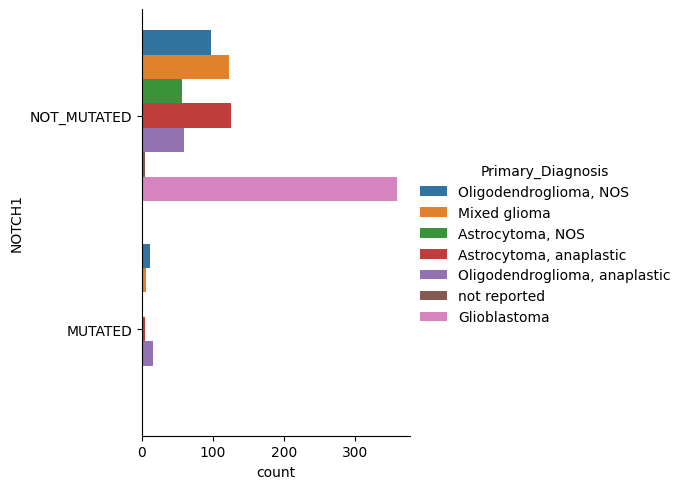

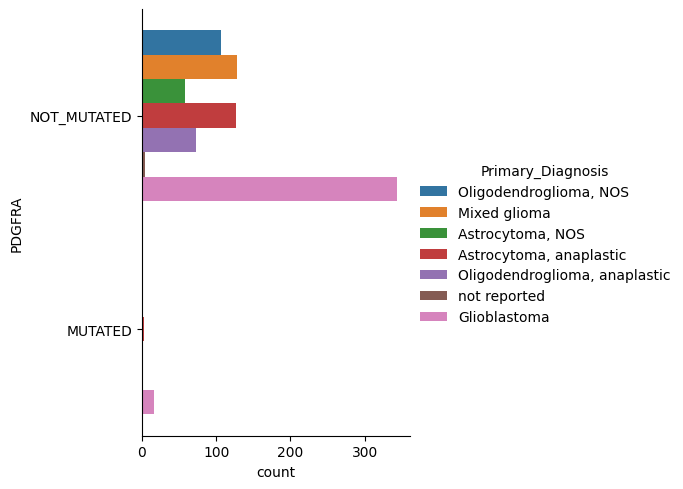

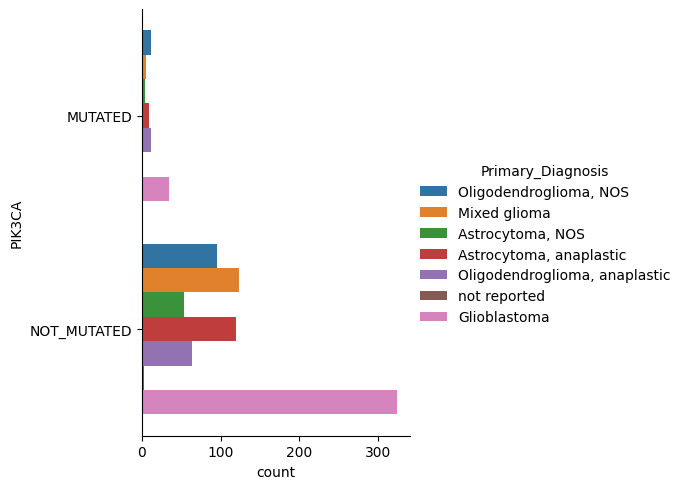

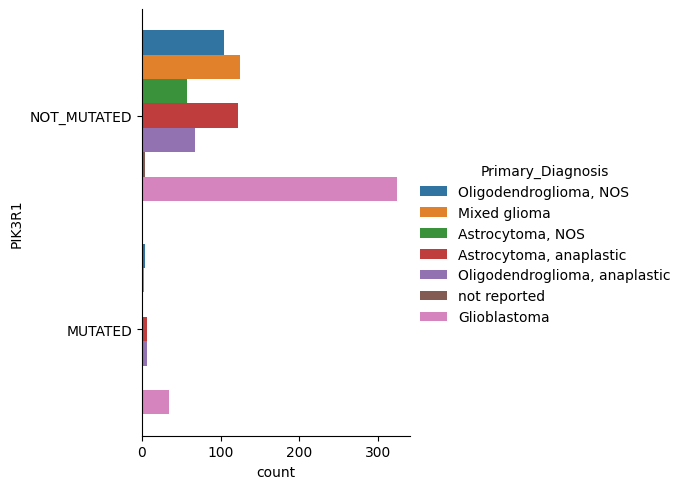

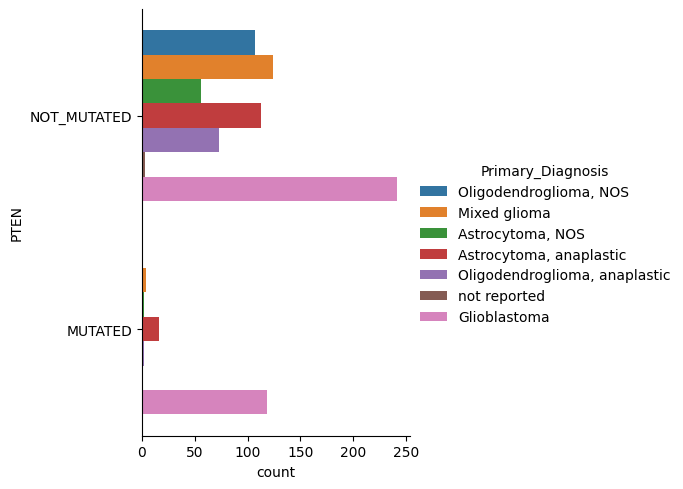

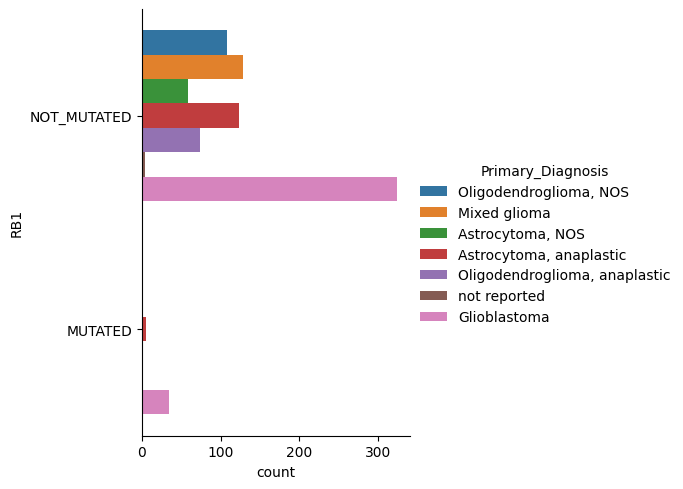

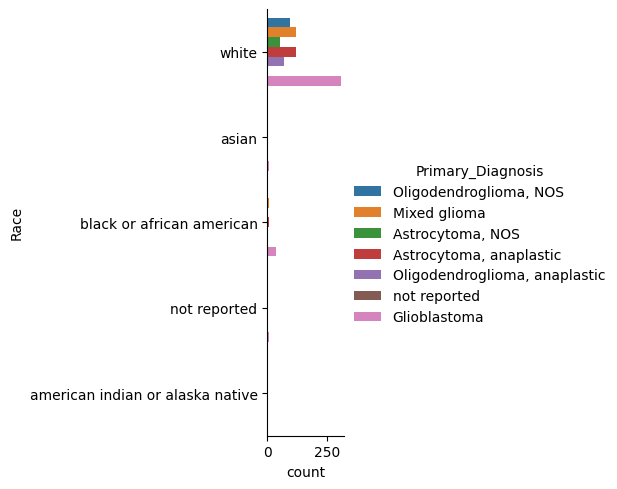

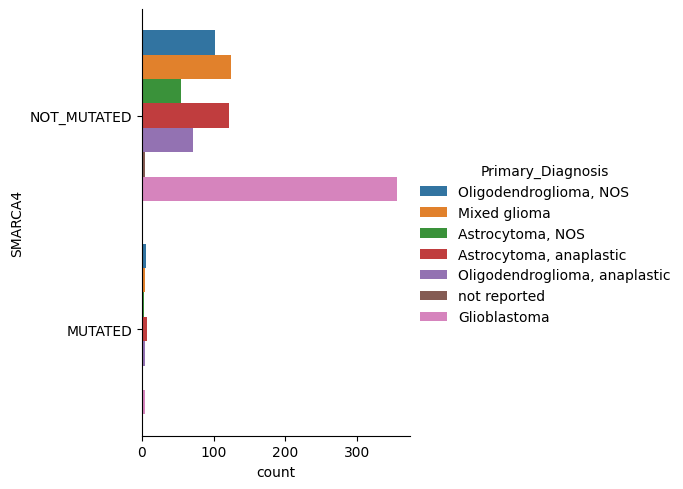

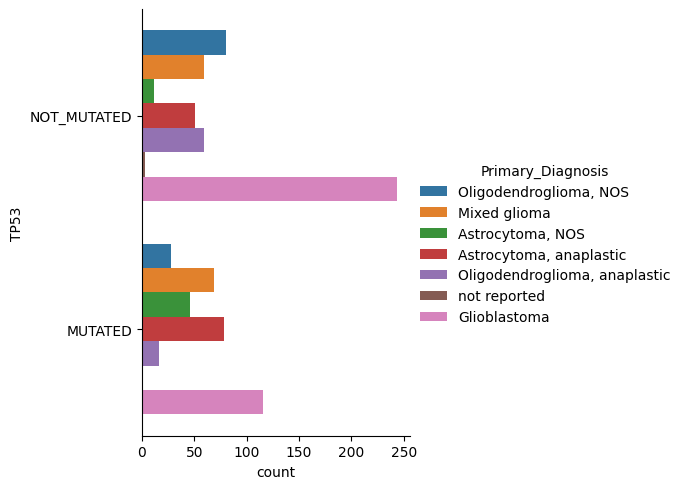

In [ ]:
for col in columns:
  sns.catplot(data[[col, 'Primary_Diagnosis']], kind ='count', y = col, hue = 'Primary_Diagnosis')

### Se convierten las variables categóricas a numéricas.

In [ ]:
label_encoder = LabelEncoder()

for col in data.columns:
  if data[col].dtypes == 'O':
    data[col] = label_encoder.fit_transform(data[col])

print(data.shape)
data.head()

(862, 25)


,Grade,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,1,1,1,4,4,0,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
1,1,1,1,3,4,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,0,0,4,0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,0,0,1,4,0,0,0,1,1,...,1,1,1,1,1,1,1,1,0,1
4,1,1,0,1,4,0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1


## 2) Clasificador


Se dividen los datos en dos variables, separando las características (`X`) de las etiquetas (`y`). Estos conjuntos a su vez se subdividen en conjuntos de entrenamiento, test y validación.

In [ ]:
X = data.drop(columns = 'Primary_Diagnosis')
y = data['Primary_Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 50)

X_test, X_val = X_test[:-10], X_test[-10:]
y_test, y_val = y_test[:-10], y_test[-10:]

print('Entrenamiento: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)
print('Validación: ', X_val.shape, y_val.shape)

Entrenamiento:  (689, 24) (689,)
Test:  (163, 24) (163,)
Validación:  (10, 24) (10,)


Se estudian distintos modelos de clasificación para seleccionar el más adecuado.

In [ ]:
tree = DecisionTreeClassifier().fit(X_train, y_train)
y_tree = tree.predict(X_test)
err_tree = 1 - accuracy_score(y_test, y_tree)

forest = RandomForestClassifier(n_estimators = 10).fit(X_train, y_train)
y_forest = forest.predict(X_test)
err_forest = 1 - accuracy_score(y_test, y_forest)

gnb = GaussianNB().fit(X_train, y_train)
y_gnb = gnb.predict(X_test)
err_gnb = 1 - accuracy_score(y_test, y_gnb)

error = pd.DataFrame({'Modelos': ['tree', 'forest', 'gnb'],
                        'Error': [err_tree, err_forest, err_gnb]})
error

,Modelos:,Error
0,tree,0.380368
1,forest,0.392638
2,gnb,0.478528


El modelo con menor error es el árbol de clasificación y, por tanto, el modelo elegido. Se entrena el modelo de nuevo con todos los datos, excepto los de validación y se clasifican estos nuevos datos.

In [ ]:
X_train = X_train.combine_first(X_test)
y_train = y_train.combine_first(y_test)

tree = DecisionTreeClassifier().fit(X_train, y_train)

y_pred = tree.predict(X_val)
err_tree = 1 - accuracy_score(y_val, y_pred)
print('Error:', err_tree)

Error: 0.4


In [ ]:
prediccion = pd.DataFrame({'Real': y_val, 'Predicción': y_pred})
prediccion

,2,636,553,767,650,77,11,537,162,18
Real,0.0,2.0,2.0,2.0,2.0,3.0,5.0,2.0,0.0,1.0
Predicción,3.0,2.0,2.0,2.0,2.0,3.0,4.0,2.0,3.0,3.0
